# Hierarchical Sampling for Active Learning

based on S. Dasgupta, D. Hsu, "Hierarchical Sampling for Active Learning" (2008). ([paper](http://www.cs.columbia.edu/~djhsu/papers/hier.pdf))

In [3]:
%matplotlib inline

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize
import scipy.ndimage

from tqdm import tqdm

from chmp.ds import mpl_set, colorize, qplot, get_color_cycle

# Active Learning code

In [5]:
"""An interpretation of Hierarchical Sampling for Active Learning.

Changes:

* use dirichlet-multinomial to estimate probabilities and errors
* use simple error reduction for splits (i.e., no admissable set)
* search of split to reduce error
"""
import itertools as it
import math
import random

import numba
import numpy as np
import scipy.cluster.hierarchy


class ActiveLearner:
    @classmethod
    def from_data(cls, x, *, n_classes, concentration=0.1, **kwargs):
        if not hasattr(x, 'shape'):
            x = np.asarray(x)

        if len(x.shape) == 1:
            x = x[:, None]

        linkage = scipy.cluster.hierarchy.linkage(x, **kwargs)
        return cls(linkage, n_classes, concentration=concentration)

    def __init__(self, linkage, n_classes, concentration=0.1, max_search_depth=3):
        self.clustering = Clustering(linkage)
        self.n_leaves = len(linkage) + 1
        self.n_nodes = 2 * len(linkage) + 1
        self.n_classes = int(n_classes)
        self.concentration = concentration
        self.max_search_depth = max_search_depth

        # counts, proba, proba-upper, proba-lower, weight, error
        self.class_count = np.zeros((self.n_nodes, self.n_classes), dtype=np.int64)
        self.class_proba = np.zeros((self.n_nodes, self.n_classes), dtype=np.float64)
        self.node_weight = np.zeros(self.n_nodes, dtype=np.int64)
        self.error = np.zeros(self.n_nodes, dtype=np.float64)
        self.majority_class = np.zeros(self.n_nodes, dtype=np.int64)

        self.pruning = [self.root]

        self._update_summaries()

    @property
    def root(self):
        return ClusterInfo(self, -1)

    @property
    def linkage(self):
        return self.clustering.linkage

    def update(self, examples, classes):
        for example, class_ in zip(examples, classes):
            self._add(example, class_)

        self._update_summaries()

    def add(self, example, class_):
        self._add(example, class_)
        self._update_summaries()

    def _add(self, example, class_):
        if example >= self.n_leaves:
            raise ValueError('can only update counts for leaves')

        _active_learner_add(self.clustering.parents, self.class_count, example, class_)

    def _update_summaries(self):
        self.node_weight[:] = self.class_count.sum(axis=1)

        alpha_i = self.concentration + self.class_count
        alpha_0 = self.n_classes * self.concentration + self.node_weight
        alpha_0 = alpha_0[:, None]

        self.class_proba[:] = alpha_i / np.maximum(1e-6, alpha_0)
        self.majority_class[:] = np.argmax(self.class_proba, axis=1)

        i = np.arange(self.n_nodes)
        a0 = alpha_0[i, 0]
        ai = alpha_i[i, self.majority_class]
        p = self.class_proba[i, self.majority_class]

        delta = np.sqrt((ai * (a0 - ai)) / np.maximum(1e-6, (a0 * a0 * (a0 + 1))))
        proba_lower = np.maximum(0, p - delta)

        self.error[:] = (1 - proba_lower)

    def split(self):
        self.pruning = [
            cluster
            for top_level in self.pruning
            for cluster in min(
                search_splittings(top_level, self.max_search_depth),
                key=calculate_splitting_error,
            )
        ]

    def propose_batch(self, size):
        cluster_weights = np.zeros(len(self.pruning), dtype=np.float64)
        root_weight = max(1, self.root.weight)

        # probably mistake in paper to use class_proba_upper
        for idx, cluster in enumerate(self.pruning):
            cluster_weights[idx] = max(1, cluster.weight) / root_weight * cluster.error

        leaf_weights = np.zeros(self.n_leaves, dtype=np.float64)
        for cluster, p in zip(self.pruning, cluster_weights):
            self.clustering.mark_leaves(cluster.id, p, leaf_weights)

        # select only unseed weights
        leaf_weights = leaf_weights * (self.node_weight[:self.n_leaves] == 0)

        assert np.all(leaf_weights >= 0)

        # normalize
        # TODO: check for nulls
        leaf_weights = leaf_weights / leaf_weights.sum()

        return np.random.choice(np.arange(self.n_leaves), size=size, p=leaf_weights, replace=False)

    def fill_proba(self):
        # use the pruning to fill cluster w/ their probabilities
        cluster_proba = np.zeros((self.n_leaves, self.n_classes), dtype=np.float)
        for cluster in self.pruning:
            for class_ in range(self.n_classes):
                self.clustering.mark_leaves(
                    cluster.id, self.class_proba[cluster.id, class_], cluster_proba[:, class_],
                )

        # get the observed probabilities
        observed_proba = self.class_count[:self.n_leaves]
        observed_proba = observed_proba / np.maximum(1, np.sum(observed_proba, axis=1, keepdims=True))

        # kepp observed probabiities, use cluster as a stand-in
        observed_leaves = self.observed_leaves[:, None]
        return (1 - observed_leaves) * cluster_proba + observed_leaves * observed_proba

    def sample_class(self):
        class_proba = self.fill_proba()
        return random_multinomial(class_proba)

    def get_class(self):
        # use the pruning to fill cluster w/ their probabilities
        cluster_class = np.zeros(self.n_leaves, dtype=np.int64)
        for cluster in self.pruning:
            self.clustering.mark_leaves(cluster.id, self.majority_class[cluster.id], cluster_class)

        # get the observed probabilities
        observed_class = self.majority_class[:self.n_leaves]

        # kepp observed probabiities, use cluster as a stand-in
        return (1 - self.observed_leaves) * cluster_class + self.observed_leaves * observed_class

    @property
    def observed_leaves(self):
        return self.node_weight[:self.n_leaves] > 0

    def get_cluster_membership(self):
        result = -np.ones(self.n_leaves, dtype=np.int64)
        for idx, cluster in enumerate(self.pruning):
            self.clustering.mark_leaves(cluster.id, idx, result)

        return result


@numba.jit(
    numba.void(numba.int64[:], numba.int64[:, :], numba.int64, numba.int64),
    nopython=True, nogil=True,
)
def _active_learner_add(parents, class_count, current, class_):
    while current >= 0:
        class_count[current, class_] += 1.0
        current = parents[current]


@numba.jit(numba.int64[:](numba.float64[:, :]))
def random_multinomial(p):
    # TODO: check input?
    res = np.empty(p.shape[0], dtype=np.int64)

    for i in range(p.shape[0]):
        u = random.random()

        j = 0
        for j in range(p.shape[1]):
            u -= p[i, j]
            if u < 0:
                break

        res[i] = j

    return res


def search_splittings(root, max_depth):
    if root.weight < 1:
        return

    yield [root]

    if max_depth == 0:
        return

    if not root.is_leaf:
        left_splits = list(search_splittings(root.left, max_depth=max_depth - 1))
        right_splits = list(search_splittings(root.right, max_depth=max_depth - 1))

        yield from (
            [*a, *b]
            for a, b in it.product(left_splits, right_splits)
        )


def calculate_splitting_error(splitting):
    return (
        sum(cluster.weight * cluster.error for cluster in splitting) /
        sum(cluster.weight for cluster in splitting)
    )


class ClusterInfo:
    def __init__(self, learner, cluster):
        if cluster < 0:
            cluster = learner.n_nodes + cluster

        assert 0 <= cluster < learner.n_nodes

        self.learner = learner
        self.id = cluster

    @property
    def weight(self):
        return self.learner.node_weight[self.id]

    @property
    def error(self):
        return self.learner.error[self.id]

    @property
    def is_leaf(self):
        return self.id < self.learner.n_leaves

    @property
    def left(self):
        assert not self.is_leaf
        return ClusterInfo(
            self.learner,
            self.learner.linkage[self.id - self.learner.n_leaves, 0],
        )

    @property
    def right(self):
        assert not self.is_leaf
        return ClusterInfo(
            self.learner,
            self.learner.linkage[self.id - self.learner.n_leaves, 1],
        )

    @property
    def should_split(self):
        if self.is_leaf:
            return False

        if self.weight == 0:
            return False

        left = self.left
        right = self.right

        if left.weight == 0 or right.weight == 0:
            return False

        combined_error = (
            left.weight / self.weight * left.error +
            right.weight / self.weight * right.error
        )
        return combined_error < self.error


class Clustering:
    def __init__(self, linkage):
        if isinstance(linkage, dict):
            self.linkage = np.zeros((len(linkage), 2), dtype=np.int64)
            for i in range(len(linkage) + 1, 2 * len(linkage) + 1):
                self.linkage[i - len(linkage) - 1, :] = linkage[i]

        else:
            linkage = np.asarray(linkage, dtype=np.int64)
            self.linkage = linkage[:, :2]

        self._parents = None

    @property
    def parents(self):
        if self._parents is None:
            self._parents = np.zeros(2 * len(self.linkage) + 1, dtype=np.int64)
            _mark_parents(self.linkage, 2 * len(self.linkage), -1, self._parents)

        return self._parents

    def mark_leaves(self, cluster_id, value=None, out=None):
        if value is None:
            value = cluster_id

        value_dtype = np.asarray(value).dtype
        if out is None:
            out = -np.ones(len(self.linkage) + 1, dtype=value_dtype)

        else:
            out = np.asarray(out, dtype=value_dtype)

        _mark_leaves(self.linkage, cluster_id, value, out)
        return out


@numba.jit(
    numba.void(numba.int64[:, :], numba.int64, numba.int64, numba.int64[:]),
    nopython=True, nogil=True,
)
def _mark_parents(linkage, child, parent, out):
    if child > 2 * len(linkage):
        raise ValueError()

    out[child] = parent

    if child > len(linkage):
        _mark_parents(linkage, linkage[child - len(linkage) - 1, 0], child, out)
        _mark_parents(linkage, linkage[child - len(linkage) - 1, 1], child, out)


@numba.jit(
    [
        numba.void(numba.int64[:, :], numba.int64, numba.int64, numba.int64[:]),
        numba.void(numba.int64[:, :], numba.int64, numba.float64, numba.float64[:]),
    ],
    nopython=True, nogil=True,
)
def _mark_leaves(linkage, cluster_id, value, out):
    if cluster_id <= len(linkage):
        out[cluster_id] = value

    elif cluster_id <= 2 * len(linkage):
        _mark_leaves(linkage, linkage[cluster_id - len(linkage) - 1, 0], value, out)
        _mark_leaves(linkage, linkage[cluster_id - len(linkage) - 1, 1], value, out)

    else:
        raise ValueError()

# Example Code

In [6]:
# fit a simple sigmoid
def optimize(x, y, x0):
    res = scipy.optimize.minimize(lambda x0: -ll(x, y, x0, 1.0), x0, method='cg')
    assert res.success, res.message
    return float(res.x), -float(res.fun)
    
    
def ll(x, y, x0, w0):
    score = sigmoid(w0 * (x - x0))
    return np.mean(y * np.log(1e-6 + score) + (1 - y) * np.log(1e-6 + 1 - score))

    
def entropy(x, x0, w0):
    p = sigmoid(w0 * (x - x0))
    return -(p * np.log(1e-3 + p) + (1 - p) * np.log(1e-3 + 1 - p))
    

def sigmoid(x):
    sel = x < 0
    res = 1.0 / (1.0 + np.exp(-np.abs(x)))
    return (1 - sel) * res + sel * (1 - res)


# smoothed histograms
def smoothed_mean(x, y, bins=200, bw=1.0, range=None):
    if range is None:
        range = (np.min(x), np.max(x))
    
    x, y = np.broadcast_arrays(x, y)
    
    binned_y, _ = np.histogram(x, bins=bins, range=range, weights=y)
    binned_y = scipy.ndimage.gaussian_filter(binned_y, bw / (range[1] - range[0]) * bins)
    
    binned_x, edges = np.histogram(x, bins=bins, range=range, weights=np.ones_like(x))
    binned_x = scipy.ndimage.gaussian_filter(binned_x, bw / (range[1] - range[0]) * bins)
    
    centers = 0.5 * (edges[1:] + edges[:-1])
    return centers, binned_y / np.maximum(1, binned_x)


def smoothed_histogram(x, bins=200, bw=1.0, range=None):
    if range is None:
        range = (np.min(x), np.max(x))
    
    binned_x, edges = np.histogram(x, bins=bins, range=range, weights=np.ones_like(x))
    binned_x = scipy.ndimage.gaussian_filter(binned_x, bw / (range[1] - range[0]) * bins)
    
    centers = 0.5 * (edges[1:] + edges[:-1])
    return centers, binned_x


# plot helper for the strategy comparion
def plot_exploration(opt_x0, results, observed):
    n = min(len(results), len(observed))
    
    for i in range(0, n, 3):
        plt.scatter(
            np.random.normal(results[i, 0], 0.01 * np.ones_like(observed[i])), 
            observed[i], 
            alpha=0.005, color='b',
        )

    plt.axhline(opt_x0, ls='--', c='r')
    plt.plot(results[:n, 0], results[:n, 1], '-.g', lw=2.0)
    mpl_set(
        xlabel='Fraction of dataset explored', ylabel='Position', 
        xformatter=lambda val, _: f'{val:.0%}',
    )

## Synthetic dataset

In [7]:
n_samples = 10_000

theta = np.asarray([0.45, 0.05, 0.05, 0.45])
mu = np.asarray([0.0, 3.0, 6.0, 9.0])
p = np.asarray([0.0, 1.0, 0.5, 1.0])

cluster = np.random.choice(np.arange(4), p=theta, size=n_samples)
x = np.random.normal(loc=mu[cluster], scale=0.25)
y = np.random.binomial(1, p[cluster])

In [8]:
centers, mean_y = smoothed_mean(x, y, range=(-2, +11), bins=31, bw=0.5)
_, count_x = smoothed_histogram(x, range=(-2, +11), bins=31, bw=0.5)

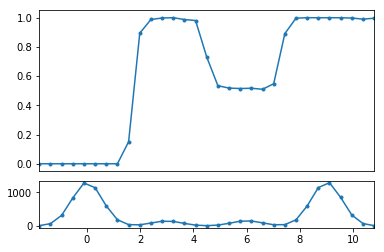

In [9]:
gs = plt.GridSpec(4, 3)

plt.subplot(gs[:-1, :])
plt.plot(centers, mean_y, marker='.')
plt.xticks([])
plt.xlim(np.min(centers), np.max(centers))

plt.subplot(gs[-1, :])
plt.plot(centers, count_x, marker='.')
plt.xlim(np.min(centers), np.max(centers))
pass

# Strategies

## Biased

In [10]:
x0 = 6.0
w0 = +1.0

selected = np.zeros_like(x, dtype=bool)
indices = np.arange(len(selected))

selected[np.random.choice(indices[cluster == 2], replace=False, size=100)] = True

biased_observed = []
biased_results = []

for step in tqdm(range(50)):
    ent = entropy(x[~selected], x0, w0)
    top = np.argsort(ent)
    top = top[-50:]
    next_idx = indices[~selected][top]
    selected[next_idx] = True

    x0, _ll = optimize(x[selected], y[selected], x0)
    biased_results.append((np.mean(selected), x0, _ll))
    biased_observed.append(np.array(x[selected]))

biased_results = np.asarray(biased_results)

100%|██████████| 50/50 [00:00<00:00, 104.94it/s]


## Random

In [11]:
selected = np.zeros_like(x, dtype=bool)
indices = np.arange(len(selected))

random_observed = []
random_results = []

for step in tqdm(range(50)):
    next_idx = np.random.choice(indices[~selected], size=50, replace=False)
    selected[next_idx] = True

    x0, _ll = optimize(x[selected], y[selected], x0)
    random_results.append((np.mean(selected), x0, _ll))
    random_observed.append(np.array(x[selected]))

random_results = np.asarray(random_results)

100%|██████████| 50/50 [00:00<00:00, 84.05it/s] 


## Hierarchical Sampling

In [12]:
learner = ActiveLearner.from_data(x, n_classes=2, concentration=1e-3)

active_results = []
active_observed = []

for step in tqdm(range(50)):
    batch = learner.propose_batch(size=50)
    
    # Note: this would be labelling procedure here
    labels = y[batch]
    
    learner.update(batch, labels)
    learner.split()
    
    active_observed.append(np.array(x[learner.observed_leaves]))
    
    y_synth = learner.get_class()
    _x0, _ll = optimize(x, y_synth, 7.0)
    active_results.append((learner.observed_leaves.mean(), _x0, _ll, len(learner.pruning)))
    
active_results = np.asarray(active_results)

100%|██████████| 50/50 [00:05<00:00,  8.41it/s]


## Comparison

In [13]:
opt_x0, _ = optimize(x, y, 7.0)

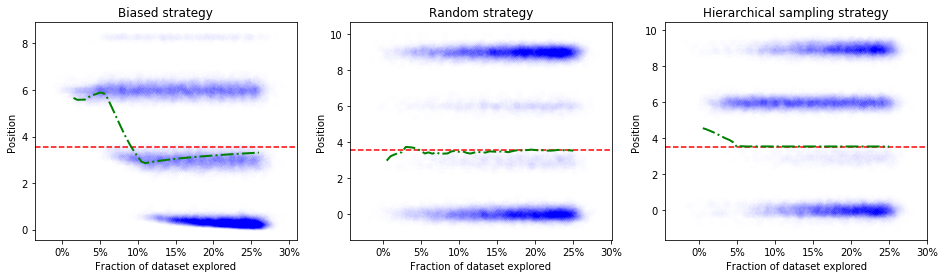

In [14]:
_, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4))

plt.sca(ax1)
plt.title('Biased strategy')
plot_exploration(opt_x0, biased_results, biased_observed)

plt.sca(ax2)
plt.title('Random strategy')
plot_exploration(opt_x0, random_results, random_observed)

plt.sca(ax3)
plt.title('Hierarchical sampling strategy')
plot_exploration(opt_x0, active_results, active_observed)

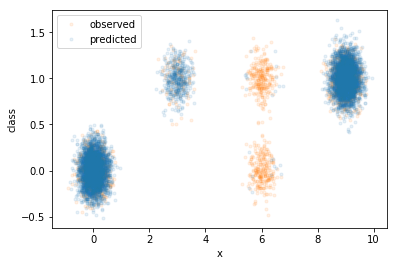

In [15]:
c0, c1 = get_color_cycle(2)

plt.plot(
    x[learner.observed_leaves], np.random.normal(y_synth[learner.observed_leaves], 0.15), 
    '.', alpha=0.1, color=c1, label='observed',
)
plt.plot(
    x[~learner.observed_leaves], np.random.normal(y_synth[~learner.observed_leaves], 0.15), 
    '.', alpha=0.1, color=c0, label='predicted',
)
mpl_set(ylabel='class', xlabel='x', legend=True)

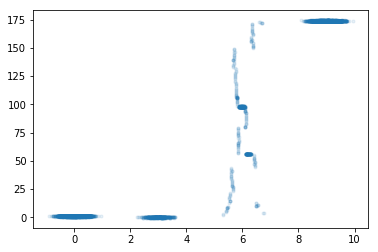

In [16]:
cluster_membership = learner.get_cluster_membership()
plt.plot(x, np.random.normal(cluster_membership, 0.15), '.', alpha=0.1)
pass

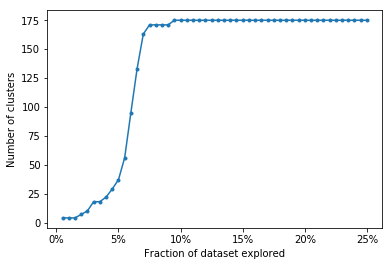

In [17]:
plt.plot(active_results[:, 0], active_results[:, -1], marker='.')
mpl_set(
    xlabel='Fraction of dataset explored', ylabel='Number of clusters', 
    xformatter=lambda val, _: f'{val:.0%}',
)

# Misc Plots

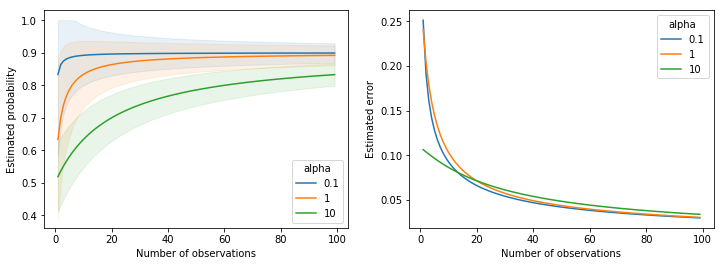

In [18]:
def compute_smoothed_proba(alpha, k, p=1.0, n_classes=2):
    alpha_i = alpha + p * k
    alpha_0 = n_classes * alpha + k
    p = alpha_i / alpha_0
    delta = np.sqrt(alpha_i * (alpha_0 - alpha_i) / (alpha_0 ** 2 * (alpha_0 + 1)))

    return p, delta


k = np.arange(1, 100)

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

for color, alpha in colorize([0.1, 1, 10]):
    proba, delta = compute_smoothed_proba(alpha, k, p=0.9)
    
    plt.sca(ax1)
    qplot(
        k, 
        np.vstack([np.maximum(0, proba - delta), proba, np.minimum(1, proba + delta)]), 
        label=str(alpha), color=color, fill_alpha=0.1,
    )
    
    plt.sca(ax2)
    plt.plot(k, delta, label=str(alpha), color=color)
    
mpl_set(
    ax=ax1, legend=dict(loc='best', title='alpha'), 
    xlabel='Number of observations', ylabel='Estimated probability',
)
mpl_set(
    ax=ax2, legend=dict(loc='best', title='alpha'), 
    xlabel='Number of observations', ylabel='Estimated error',
)

## Different fill strategies

In [19]:
res = []
pmax = []
q = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
n = 5

for a in np.arange(0.1, 10, 0.3):
    p = np.random.dirichlet([a] * 3, size=100_000)
    
    pmax.append(np.mean(p.max(axis=1)))
    res.append((
        np.percentile((1 - p.max(axis=1)), q),
        np.percentile((p * (1 - p)).sum(axis=1), q)
    ))
    
res = np.asarray(res)

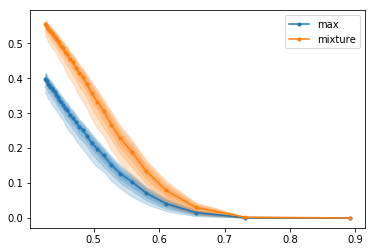

In [20]:
qplot(pmax, res[..., 0, :].T, marker='.', label='max')
qplot(pmax, res[..., 1, :].T, marker='.', label='mixture')
mpl_set(legend=True)